In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from copy import deepcopy
import warnings
import logging

tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Helper Functions

In [4]:
def df_to_X_y_split_linear(df, y_index, valid=.20, test=.20, split=(0,0,0)):
  df_length = len(df)
  test_length = int(df_length - (df_length / (1/test)))
  valid_length = int(df_length - (df_length / (1/(valid+test))))
  df = df.to_numpy()
  X = []
  y = []
  for i in range(df_length):
    row = df[i][:y_index]
    X.append(row)
    label = df[i][y_index]
    y.append(label)
  X, y = np.array(X), np.array(y)

  if split[0] == split[1] == split[2] == 0:
    X_train_all, y_train_all = X[:test_length], y[:test_length]
    X_train, y_train = X[:valid_length], y[:valid_length]
    X_valid, y_valid = X[valid_length:test_length], y[valid_length:test_length]
    X_test, y_test = X[test_length:], y[test_length:]
  else:
    X_train, y_train = X[:split[0]], y[:split[0]]
    X_valid, y_valid = X[split[1]:split[2]], y[split[1]:split[2]]
    X_test, y_test = X[split[2]:], y[split[2]:]
    X_train_all, y_train_all = np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid))

  return X_train_all, y_train_all, X_train, y_train, X_valid, y_valid, X_test, y_test

def convert_2d(df):
  n_samples, n_x, n_y = df.shape
  df_2d = df.reshape((n_samples, n_x*n_y))
  return df_2d
  
def df_to_X_y_split(df, y_index, window_size=4, valid=.20, test=.20, x_index = 0, split=(0,0,0)):
  df_length = len(df)
  test_length = int(df_length - (df_length / (1/test)))
  valid_length = int(df_length - (df_length / (1/(valid+test))))
  df = df.to_numpy()
  X = []
  y = []
  for i in range(df_length-window_size):
    if x_index == 0:
      row = df[i:i+window_size]
    else:
      row = df[i:i+window_size,x_index]
    X.append(row)
    label = df[i+window_size][y_index]
    y.append(label)
  X, y = np.array(X), np.array(y)

  if split[0] == split[1] == split[2] == 0:
    X_train_all, y_train_all = X[:test_length], y[:test_length]
    X_train, y_train = X[:valid_length], y[:valid_length]
    X_valid, y_valid = X[valid_length:test_length], y[valid_length:test_length]
    X_test, y_test = X[test_length:], y[test_length:]
  else:
    X_train, y_train = X[:split[0]], y[:split[0]]
    X_valid, y_valid = X[split[1]:split[2]], y[split[1]:split[2]]
    X_test, y_test = X[split[2]:], y[split[2]:]
    X_train_all, y_train_all = np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid))

  return X_train_all, y_train_all, X_train, y_train, X_valid, y_valid, X_test, y_test

def plot_predictions(model, X, y, start=0, end=0, title = '', save = True, show = True, predict_all_y_window = 0, is_2d = False):
  XX = deepcopy(X)
  if end == 0: end = len(XX)
  if predict_all_y_window > 0:
    if is_2d:
      n_window = predict_all_y_window
      n_features = XX.shape[1]//n_window
    else:
      n_window, n_features = XX[0].shape
    predictions = []
    for x in range(len(XX)):
      prediction = model.predict([XX[x]])[0]
      if is_2d:
        for i in range(n_window):
          I = i+1
          U = n_features
          if I+x < len(XX):
            XX[I+x][-1-((U)*i)] = prediction
      else:
        for i in range(n_window):
          I = i+1
          XX[I+x][n_window-I][-1] = prediction
      predictions.append(prediction)
    predictions = np.array(predictions).flatten()
  else:
    predictions = model.predict(XX).flatten()
  rmse = mean_squared_error(y, predictions, squared=False)
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  f, ax = plt.subplots(figsize=(20, 5))
  f.patch.set_facecolor('white')
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  plt.legend(labels=['Train Predictions','Actual'])
  plt.title('%s RMSE: %.0f' % (title, rmse))
  plt.tight_layout()
  if save: plt.savefig('plots/%s-%.0f.png' % (title, rmse))
  if show: plt.show()
  plt.close()
  return df, rmse

## Load RAW Dataset *

In [3]:
# Load the main dataset
df = pd.read_csv('dataset.csv', parse_dates=True)

# Clean the data
df = df.drop(columns=['Year.1', 'Month.1', 'Day.1', 'Hour.1','Minute'])
df = df.rename(columns={"Solar Zenith Angle":"Solar Zenith","WIND TOTAL": "WIND", "Global Horizontal UV Irradiance (280-400nm)": "Horizontal UVI<400nm", "Global Horizontal UV Irradiance (295-385nm)": "Horizontal UVI<385nm"})

# Filter and Re-order
df["SOLAR"] = df["SOLAR PV"] + df["SOLAR THERMAL"]
df['Date'] = df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1) + ' ' + df['Hour'].astype(str) + ':00:00'
df['Date'] = pd.to_datetime(df['Date'].astype(str))
df = df[['Date', 'Year', 'Month', 'Day', 'Hour', 'DHI', 'DNI', 'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Horizontal UVI<400nm', 'Horizontal UVI<385nm', 'Solar Zenith', 'Cloud Type', 'Fill Flag', 'Dew Point', 'Surface Albedo', 'Precipitable Water', 'Relative Humidity', 'Temperature', 'Wind Speed', 'Wind Direction', 'Pressure', 'WIND', 'SOLAR', 'SOLAR PV', 'SOLAR THERMAL', 'GEOTHERMAL', 'BIOMASS', 'BIOGAS', 'SMALL HYDRO', 'HYDRO', 'NUCLEAR', 'THERMAL', 'IMPORTS', 'RENEWABLES']]

# Set date as dataset's index
df.set_index(['Date'], inplace=True)

# Outlier
df_small = df.query("`Month` == 2 and `Year` == 2020 and (`Day` < 26 or (`Day` == 26 and `Hour` < 9))")[['WIND']]
df_small.describe()
# 14642 2020-2-1 1:0
# 15250 2020-2-26 8:0
# this data needs to be re-calculated using single feature time-series prediction

# Feature Engineering
df_solar = df[['DHI', 'DNI', 'GHI', 'Horizontal UVI<400nm', 'Solar Zenith', 'Cloud Type', 'Relative Humidity', 'Temperature', 'Precipitable Water', 'SOLAR']]
df_wind = df[['Cloud Type', 'Dew Point', 'Precipitable Water', 'Wind Speed', 'Wind Direction', 'Pressure', 'WIND']]

y_index = -1

## Replace missing values *

In [5]:
X_train_all_wind_3_missing, y_train_all_wind_3_missing, X_train_wind_3_missing, y_train_wind_3_missing, X_valid_wind_3_missing, y_valid_wind_3_missing, X_test_wind_3_missing, y_test_wind_3_missing = \
    df_to_X_y_split(df_wind, y_index, 3, split=(14610,14610,15270))

X_train_all_wind_3_missing_2d = convert_2d(X_train_all_wind_3_missing)
X_train_wind_3_missing_2d = convert_2d(X_train_wind_3_missing)
X_valid_wind_3_missing_2d = convert_2d(X_valid_wind_3_missing)
X_test_wind_3_missing_2d = convert_2d(X_test_wind_3_missing)

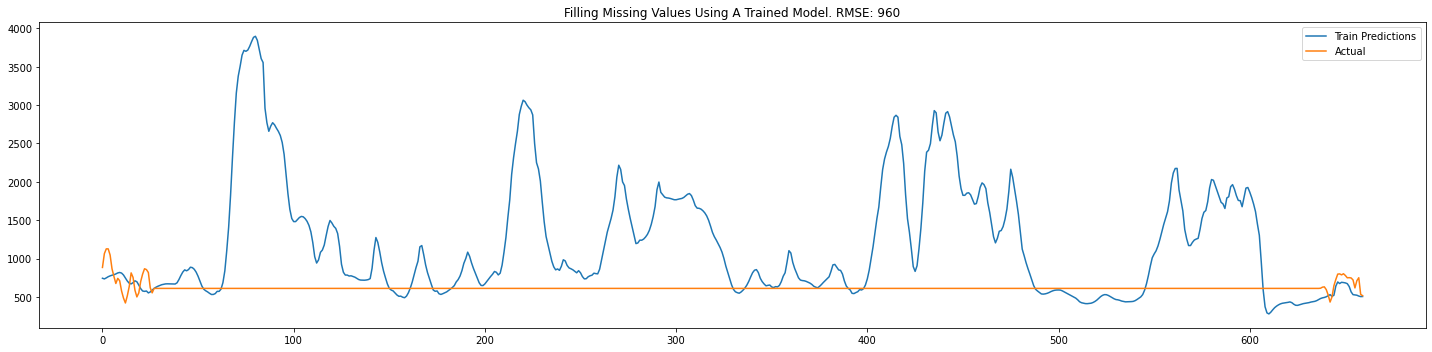

In [6]:
for kernel in ['rbf']:
  for C in [5000]:
      for gamma in [0.000005]:
        wind_missing_svr = SVR(kernel = kernel, C=C, gamma=gamma)
        wind_missing_svr.fit(X_train_wind_3_missing_2d, y_train_wind_3_missing)
        df_filled, rmse = plot_predictions(wind_missing_svr, X_valid_wind_3_missing_2d, y_valid_wind_3_missing,title='Filling Missing Values Using A Trained Model.', save=True, predict_all_y_window=3, is_2d=True)

<AxesSubplot:xlabel='Date'>

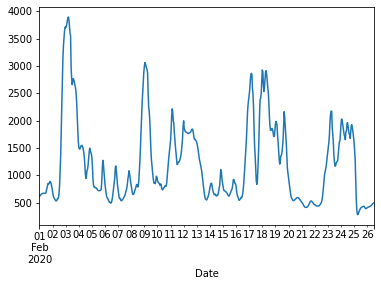

In [9]:
# replace missing values with training predictions
# df_filled.iloc[27:641,0].plot()
# df_wind.iloc[14610+27+3:14610+641+3, y_index] = df_filled.iloc[27:641,0]
# df_wind.iloc[14610+27+3:14610+641+3, y_index].plot()

In [11]:
# save new datasets
df_solar.to_csv('dataset_solar.csv')
df_wind.to_csv('dataset_wind.csv')

## Re-Load & Split Dataset

In [7]:
# load new datasets
df_solar = pd.read_csv('dataset_solar.csv', parse_dates=True)
df_wind = pd.read_csv('dataset_wind.csv', parse_dates=True)
df_solar.set_index(['Date'], inplace=True)
df_wind.set_index(['Date'], inplace=True)

In [8]:
y_index = -1

X_train_all_solar_4, y_train_all_solar_4, X_train_solar_4, y_train_solar_4, X_valid_solar_4, y_valid_solar_4, X_test_solar_4, y_test_solar_4 = \
    df_to_X_y_split(df_solar, y_index, 4)
X_train_all_wind_4, y_train_all_wind_4, X_train_wind_4, y_train_wind_4, X_valid_wind_4, y_valid_wind_4, X_test_wind_4, y_test_wind_4 = \
    df_to_X_y_split(df_wind, y_index, 4)

X_train_all_solar_4_2d = convert_2d(X_train_all_solar_4)
X_train_solar_4_2d = convert_2d(X_train_solar_4)
X_valid_solar_4_2d = convert_2d(X_valid_solar_4)
X_test_solar_4_2d = convert_2d(X_test_solar_4)
X_train_all_wind_4_2d = convert_2d(X_train_all_wind_4)
X_train_wind_4_2d = convert_2d(X_train_wind_4)
X_valid_wind_4_2d = convert_2d(X_valid_wind_4)
X_test_wind_4_2d = convert_2d(X_test_wind_4)

X_train_all_solar_3, y_train_all_solar_3, X_train_solar_3, y_train_solar_3, X_valid_solar_3, y_valid_solar_3, X_test_solar_3, y_test_solar_3 = \
    df_to_X_y_split(df_solar, y_index, 3)
X_train_all_wind_3, y_train_all_wind_3, X_train_wind_3, y_train_wind_3, X_valid_wind_3, y_valid_wind_3, X_test_wind_3, y_test_wind_3 = \
    df_to_X_y_split(df_wind, y_index, 3)

X_train_all_solar_3_2d = convert_2d(X_train_all_solar_3)
X_train_solar_3_2d = convert_2d(X_train_solar_3)
X_valid_solar_3_2d = convert_2d(X_valid_solar_3)
X_test_solar_3_2d = convert_2d(X_test_solar_3)
X_train_all_wind_3_2d = convert_2d(X_train_all_wind_3)
X_train_wind_3_2d = convert_2d(X_train_wind_3)
X_valid_wind_3_2d = convert_2d(X_valid_wind_3)
X_test_wind_3_2d = convert_2d(X_test_wind_3)

X_train_all_solar_6, y_train_all_solar_6, X_train_solar_6, y_train_solar_6, X_valid_solar_6, y_valid_solar_6, X_test_solar_6, y_test_solar_6 = \
    df_to_X_y_split(df_solar, y_index, 6)
X_train_all_wind_6, y_train_all_wind_6, X_train_wind_6, y_train_wind_6, X_valid_wind_6, y_valid_wind_6, X_test_wind_6, y_test_wind_6 = \
    df_to_X_y_split(df_wind, y_index, 6)

X_train_all_solar_6_2d = convert_2d(X_train_all_solar_6)
X_train_solar_6_2d = convert_2d(X_train_solar_6)
X_valid_solar_6_2d = convert_2d(X_valid_solar_6)
X_test_solar_6_2d = convert_2d(X_test_solar_6)
X_train_all_wind_6_2d = convert_2d(X_train_all_wind_6)
X_train_wind_6_2d = convert_2d(X_train_wind_6)
X_valid_wind_6_2d = convert_2d(X_valid_wind_6)
X_test_wind_6_2d = convert_2d(X_test_wind_6)

X_train_all_solar_4_i, y_train_all_solar_4_i, X_train_solar_4_i, y_train_solar_4_i, X_valid_solar_4_i, y_valid_solar_4_i, X_test_solar_4_i, y_test_solar_4_i = \
    df_to_X_y_split(df_solar, y_index, window_size=4, x_index = y_index)
X_train_all_wind_4_i, y_train_all_wind_4_i, X_train_wind_4_i, y_train_wind_4_i, X_valid_wind_4_i, y_valid_wind_4_i, X_test_wind_4_i, y_test_wind_4_i = \
    df_to_X_y_split(df_wind, y_index, window_size=4, x_index = y_index)

X_train_all_solar_3_i, y_train_all_solar_3_i, X_train_solar_3_i, y_train_solar_3_i, X_valid_solar_3_i, y_valid_solar_3_i, X_test_solar_3_i, y_test_solar_3_i = \
    df_to_X_y_split(df_solar, y_index, 3, x_index = y_index)
X_train_all_wind_3_i, y_train_all_wind_3_i, X_train_wind_3_i, y_train_wind_3_i, X_valid_wind_3_i, y_valid_wind_3_i, X_test_wind_3_i, y_test_wind_3_i = \
    df_to_X_y_split(df_wind, y_index, 3, x_index = y_index)

X_train_all_solar_6_i, y_train_all_solar_6_i, X_train_solar_6_i, y_train_solar_6_i, X_valid_solar_6_i, y_valid_solar_6_i, X_test_solar_6_i, y_test_solar_6_i = \
    df_to_X_y_split(df_solar, y_index, 6, x_index = y_index)
X_train_all_wind_6_i, y_train_all_wind_6_i, X_train_wind_6_i, y_train_wind_6_i, X_valid_wind_6_i, y_valid_wind_6_i, X_test_wind_6_i, y_test_wind_6_i = \
    df_to_X_y_split(df_wind, y_index, 6, x_index = y_index)

X_train_all_solar, y_train_all_solar, X_train_solar, y_train_solar, X_valid_solar, y_valid_solar, X_test_solar, y_test_solar = \
    df_to_X_y_split_linear(df_solar, -1)
X_train_all_wind, y_train_all_wind, X_train_wind, y_train_wind, X_valid_wind, y_valid_wind, X_test_wind, y_test_wind = \
    df_to_X_y_split_linear(df_wind, -1)

# Training

## 1. Linear Regression

### A) Using only the meteorological dataset as X

In [66]:
wind_lr_A = LinearRegression()
wind_lr_A.fit(X_train_wind, y_train_wind)
_, rmse = plot_predictions(wind_lr_A, X_valid_wind, y_valid_wind, title='WIND LR Training.', save=False, show=False)
print('WIND', rmse)

solar_lr_A = LinearRegression()
solar_lr_A.fit(X_train_solar, y_train_solar)
_, rmse = plot_predictions(solar_lr_A, X_valid_solar, y_valid_solar, title='SOLAR LR Training.', save=False, show=False)
print('SOLAR', rmse)

WIND 1045.2554105639524
SOLAR 1360.7971523618958


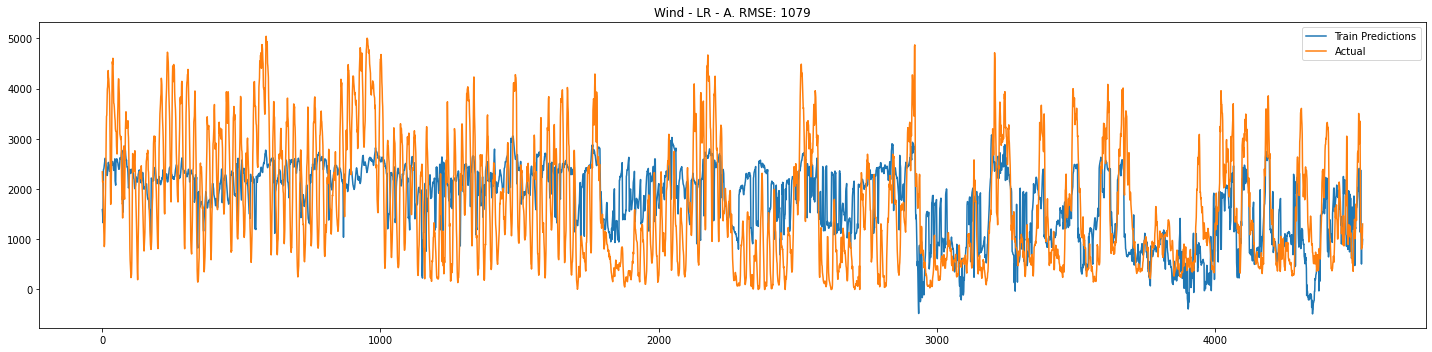

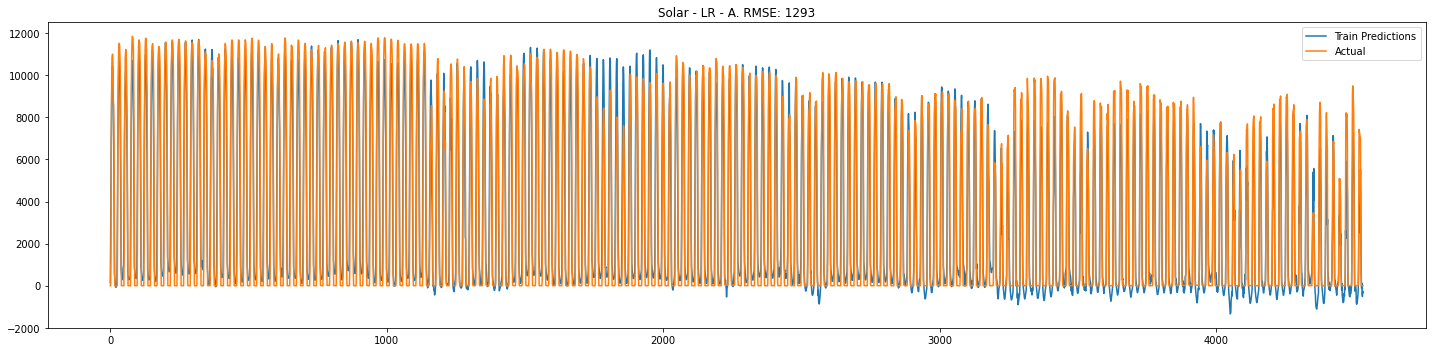

In [67]:
wind_lr_A_t = LinearRegression()
wind_lr_A_t.fit(X_train_all_wind, y_train_all_wind)
_, rmse = plot_predictions(wind_lr_A_t, X_test_wind, y_test_wind,title='Wind - LR - A.', save=True)

solar_lr_A_t = LinearRegression()
solar_lr_A_t.fit(X_train_all_solar, y_train_all_solar)
_, rmse = plot_predictions(solar_lr_A_t, X_test_solar, y_test_solar,title='Solar - LR - A.', save=True)

### B) Using the last four sequences of the generation dataset as X

In [70]:
wind_lr_B = LinearRegression()
wind_lr_B.fit(X_train_wind_4_i, y_train_wind_4_i)
_, rmse = plot_predictions(wind_lr_B, X_valid_wind_4_i, y_valid_wind_4_i, title='WIND LR Training.', save=False, show=False)
print('WIND', rmse)

solar_lr_B = LinearRegression()
solar_lr_B.fit(X_train_solar_4_i, y_train_solar_4_i)
_, rmse = plot_predictions(solar_lr_B, X_valid_solar_4_i, y_valid_solar_4_i, title='SOLAR LR Training.', save=False, show=False)
print('SOLAR', rmse)

WIND 220.59104986822769
SOLAR 872.1656905175189


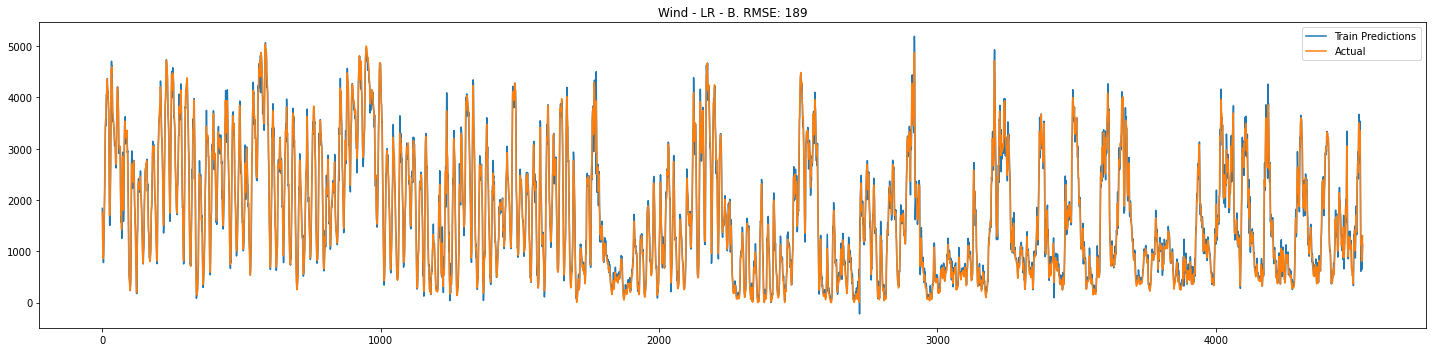

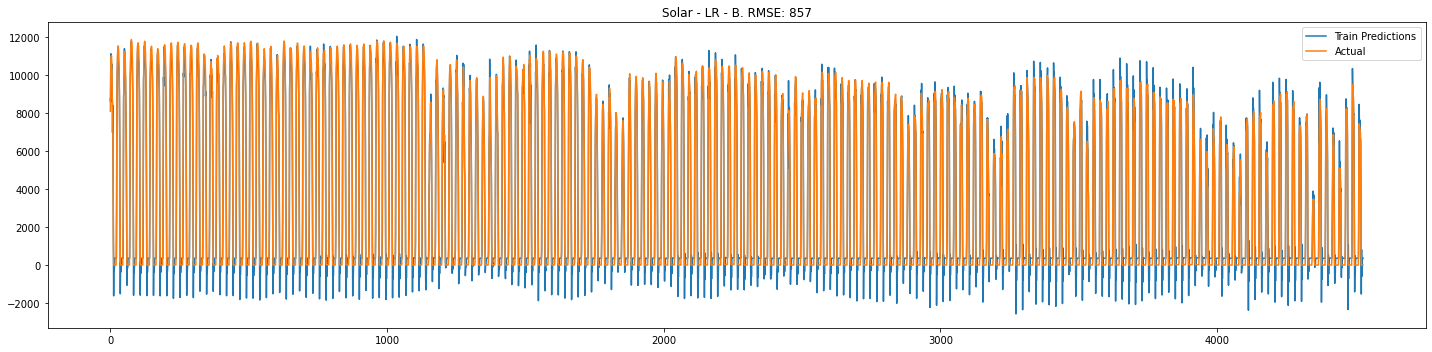

In [71]:
wind_lr_B_t = LinearRegression()
wind_lr_B_t.fit(X_train_all_wind_4_i, y_train_all_wind_4_i)
_, rmse = plot_predictions(wind_lr_B_t, X_test_wind_4_i, y_test_wind_4_i,title='Wind - LR - B.', save=True)

solar_lr_B_t = LinearRegression()
solar_lr_B_t.fit(X_train_all_solar_4_i, y_train_all_solar_4_i)
_, rmse = plot_predictions(solar_lr_B_t, X_test_solar_4_i, y_test_solar_4_i,title='Solar - LR - B.', save=True)

### C) Using the last four sequences of the entire dataset

In [68]:
wind_lr_C = LinearRegression()
wind_lr_C.fit(X_train_wind_4_2d, y_train_wind_4)
_, rmse = plot_predictions(wind_lr_C, X_valid_wind_4_2d, y_valid_wind_4, title='WIND LR Training.', save=False, show=False)
print('WIND', rmse)

solar_lr_C = LinearRegression()
solar_lr_C.fit(X_train_solar_4_2d, y_train_solar_4)
_, rmse = plot_predictions(solar_lr_C, X_valid_solar_4_2d, y_valid_solar_4, title='SOLAR LR Training.', save=False, show=False)
print('SOLAR', rmse)

WIND 215.21372108619866
SOLAR 1132.0709179971418


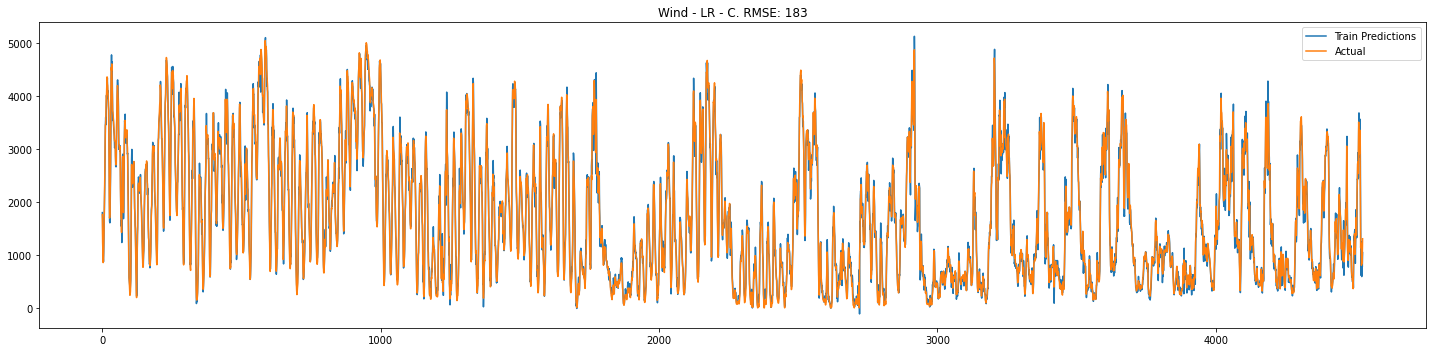

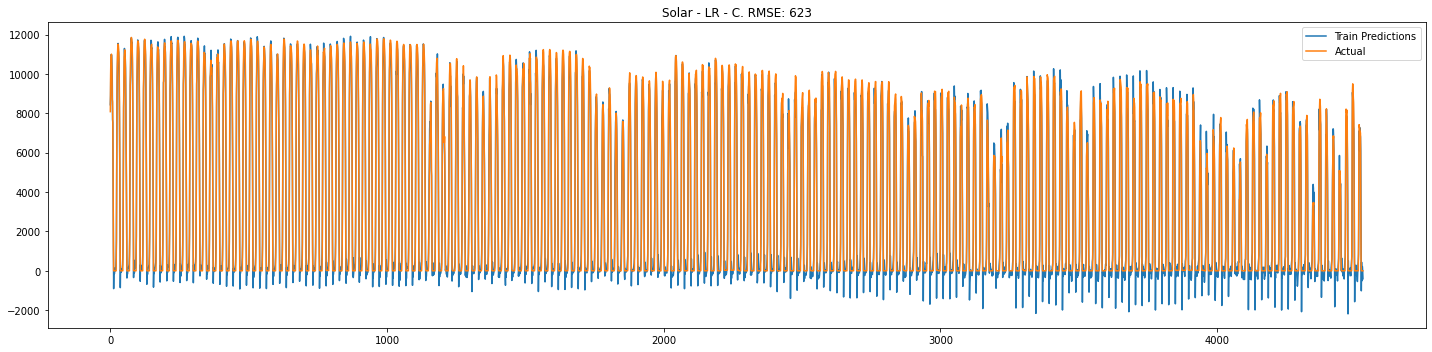

In [69]:
wind_lr_C_t = LinearRegression()
wind_lr_C_t.fit(X_train_all_wind_4_2d, y_train_all_wind_4)
_, rmse = plot_predictions(wind_lr_C_t, X_test_wind_4_2d, y_test_wind_4,title='Wind - LR - C.', save=True)

solar_lr_C_t = LinearRegression()
solar_lr_C_t.fit(X_train_all_solar_4_2d, y_train_all_solar_4)
_, rmse = plot_predictions(solar_lr_C_t, X_test_solar_4_2d, y_test_solar_4,title='Solar - LR - C.', save=True)

## 2. GBoost

### A) Using only the meteorological dataset as X

In [78]:
estimators, max_depth, lrt = 500, 20, .001
wind_gb_A = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
wind_gb_A.fit(X_train_wind, y_train_wind)
_, rmse = plot_predictions(wind_gb_A, X_valid_wind, y_valid_wind, title='WIND GBoost Training.', save=False, show=False)
print('WIND', rmse)

estimators, max_depth, lrt = 500, 20, .005
solar_gb_A = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
solar_gb_A.fit(X_train_solar, y_train_solar)
_, rmse = plot_predictions(solar_gb_A, X_valid_solar, y_valid_solar, title='SOLAR GBoost Training.', save=False, show=False)
print('SOLAR', rmse)

WIND 1375.9407362744612
SOLAR 1885.863524615594


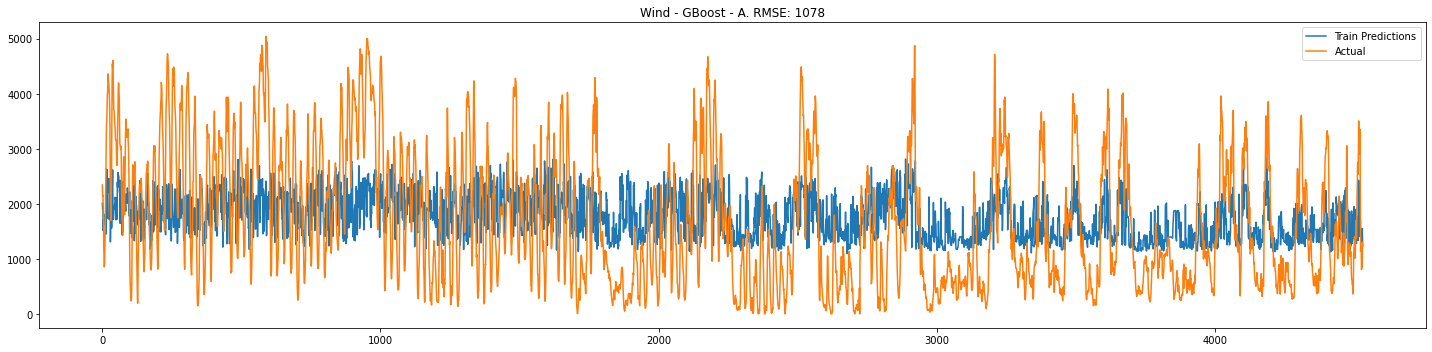

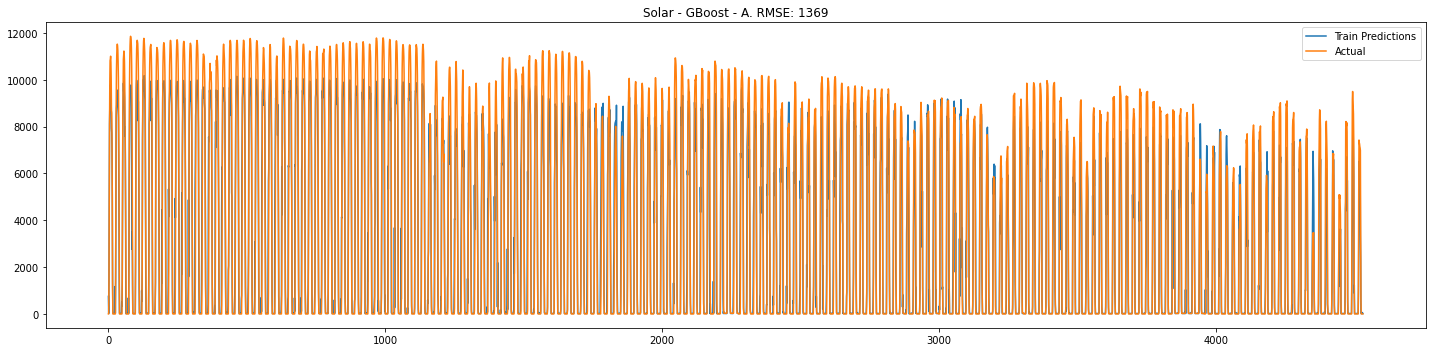

In [79]:
estimators, max_depth, lrt = 500, 20, .001
wind_gb_A_t = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
wind_gb_A_t.fit(X_train_all_wind, y_train_all_wind)
_, rmse = plot_predictions(wind_gb_A_t, X_test_wind, y_test_wind,title='Wind - GBoost - A.', save=True)

estimators, max_depth, lrt = 500, 20, .005
solar_gb_A_t = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
solar_gb_A_t.fit(X_train_all_solar, y_train_all_solar)
_, rmse = plot_predictions(solar_gb_A_t, X_test_solar, y_test_solar,title='Solar - GBoost - A.', save=True)

### B) Using the last four sequences of the generation dataset as X

In [95]:
estimators, max_depth, lrt = 500, 10, .1
wind_gb_B = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
wind_gb_B.fit(X_train_wind_4_i, y_train_wind_4_i)
_, rmse = plot_predictions(wind_gb_B, X_valid_wind_4_i, y_valid_wind_4_i, title='WIND GBoost Training.', save=False, show=False)
print('WIND', rmse)

estimators, max_depth, lrt = 500, 20, 1
solar_gb_B = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
solar_gb_B.fit(X_train_solar_4_i, y_train_solar_4_i)
_, rmse = plot_predictions(solar_gb_B, X_valid_solar_4_i, y_valid_solar_4_i, title='SOLAR GBoost Training.', save=False, show=False)
print('SOLAR', rmse)
# 315 949

WIND 316.46130056246943
SOLAR 964.6002804110157


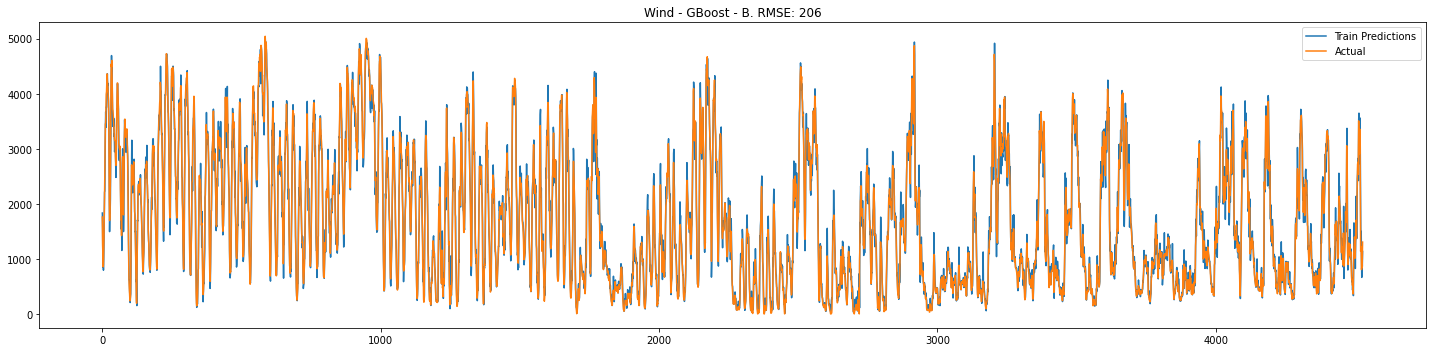

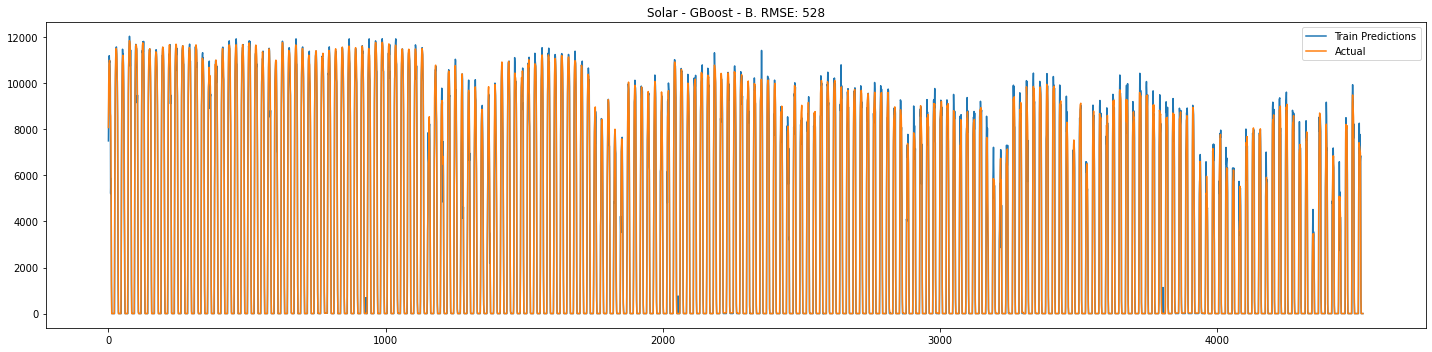

In [96]:
estimators, max_depth, lrt = 500, 10, .1
wind_gb_B_t = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
wind_gb_B_t.fit(X_train_all_wind_4_i, y_train_all_wind_4_i)
_, rmse = plot_predictions(wind_gb_B_t, X_test_wind_4_i, y_test_wind_4_i,title='Wind - GBoost - B.', save=True)

estimators, max_depth, lrt = 500, 20, 1
solar_gb_B_t = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
solar_gb_B_t.fit(X_train_all_solar_4_i, y_train_all_solar_4_i)
_, rmse = plot_predictions(solar_gb_B_t, X_test_solar_4_i, y_test_solar_4_i,title='Solar - GBoost - B.', save=True)

### C) Using the last four sequences of the entire dataset

In [104]:
estimators, max_depth, lrt = 1000, 10, .05
wind_gb_C = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
wind_gb_C.fit(X_train_wind_4_2d[:500], y_train_wind_4[:500])
_, rmse = plot_predictions(wind_gb_C, X_valid_wind_4_2d, y_valid_wind_4, title='WIND GBoost Training.', save=False, show=False)
print('WIND', rmse)

estimators, max_depth, lrt = 1000, 10, .1
solar_gb_C = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
solar_gb_C.fit(X_train_solar_4_2d[:500], y_train_solar_4[:500])
_, rmse = plot_predictions(solar_gb_C, X_valid_solar_4_2d, y_valid_solar_4, title='SOLAR GBoost Training.', save=False, show=False)
print('SOLAR', rmse)

WIND 343.90517036318175
SOLAR 1321.433513826419


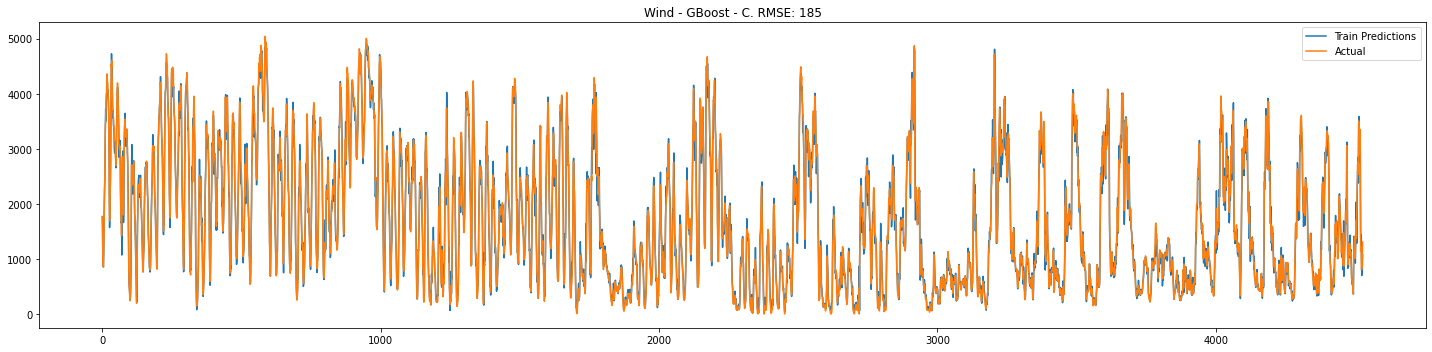

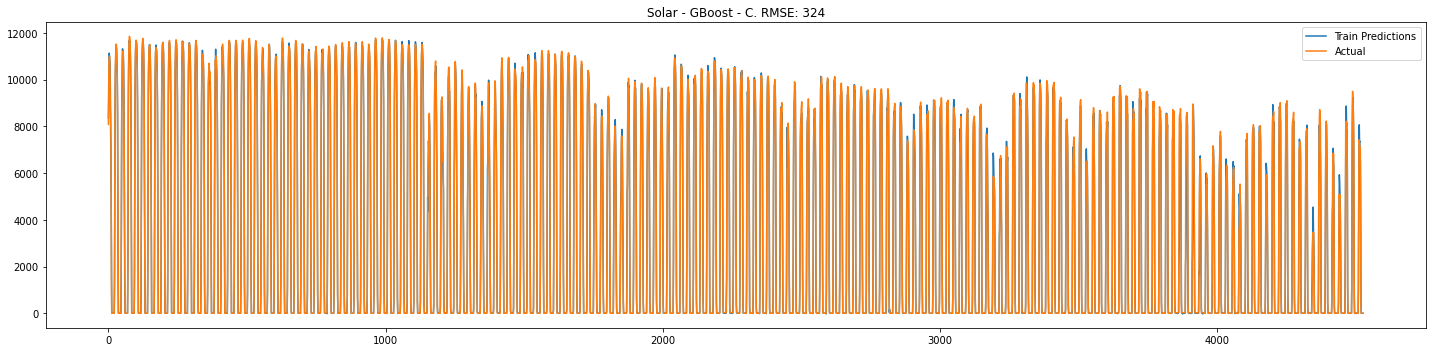

In [105]:
estimators, max_depth, lrt = 1000, 10, .05
wind_gb_C_t = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
wind_gb_C_t.fit(X_train_all_wind_4_2d, y_train_all_wind_4)
_, rmse = plot_predictions(wind_gb_C_t, X_test_wind_4_2d, y_test_wind_4,title='Wind - GBoost - C.', save=True)

estimators, max_depth, lrt = 1000, 10, .1
solar_gb_C_t = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
solar_gb_C_t.fit(X_train_all_solar_4_2d, y_train_all_solar_4)
_, rmse = plot_predictions(solar_gb_C_t, X_test_solar_4_2d, y_test_solar_4,title='Solar - GBoost - C.', save=True)

## 3. XGBoost

### A) Using only the meteorological dataset as X

In [132]:
estimators, max_depth, lrt = 1000, 5, .01
wind_xgb_A = XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lrt, max_depth=max_depth, n_estimators=estimators)
wind_xgb_A.fit(X_train_wind, y_train_wind)
_, rmse = plot_predictions(wind_xgb_A, X_valid_wind, y_valid_wind, title='WIND XGBoost Training.', save=False, show=False)
print('WIND', rmse)

estimators, max_depth, lrt = 1000, 5, .05
solar_xgb_A = XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lrt, max_depth=max_depth, n_estimators=estimators)
solar_xgb_A.fit(X_train_solar, y_train_solar)
_, rmse = plot_predictions(solar_xgb_A, X_valid_solar, y_valid_solar, title='SOLAR XGBoost Training.', save=False, show=False)
print('SOLAR', rmse)

WIND 1016.8546398803974
SOLAR 1181.1129338471778


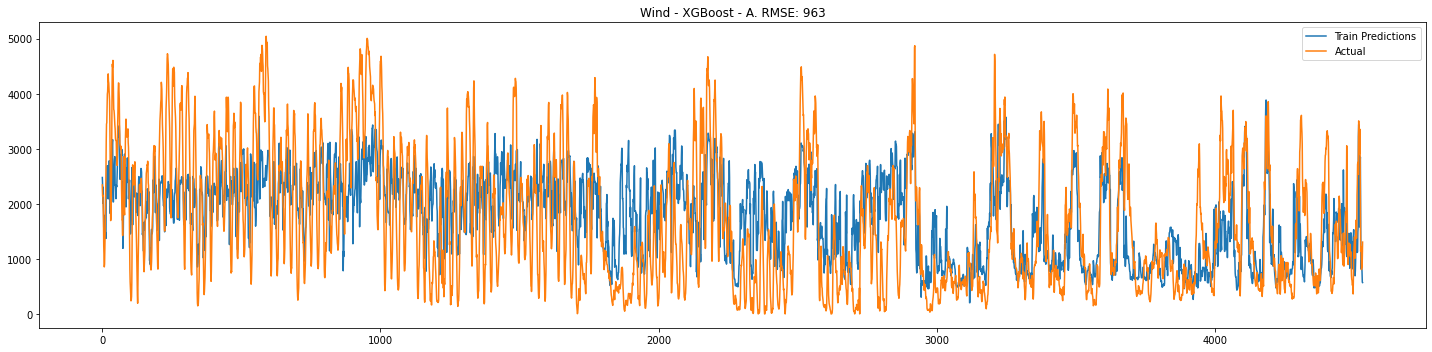

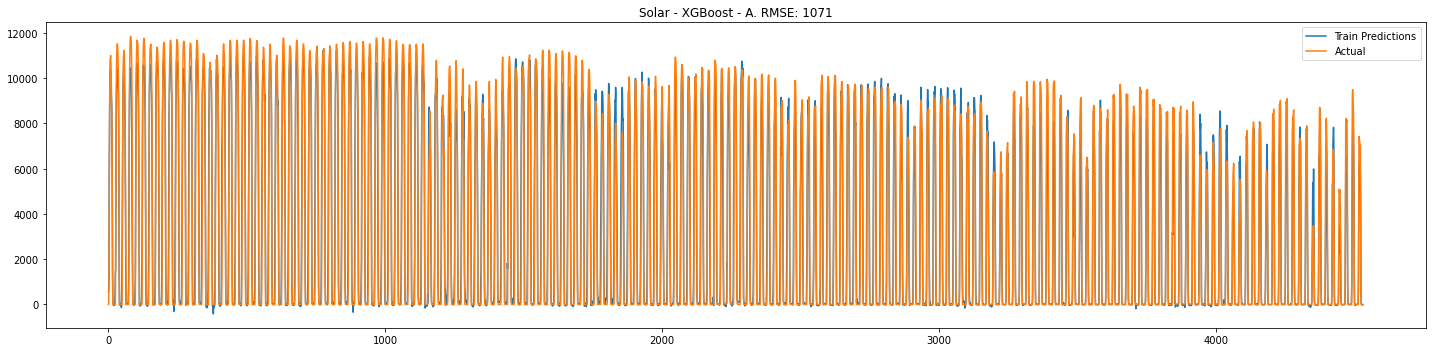

In [131]:
estimators, max_depth, lrt = 1000, 5, .01
wind_xgb_A_t = XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lrt, max_depth=max_depth, n_estimators=estimators)
wind_xgb_A_t.fit(X_train_all_wind, y_train_all_wind)
_, rmse = plot_predictions(wind_xgb_A_t, X_test_wind, y_test_wind,title='Wind - XGBoost - A.', save=True)

estimators, max_depth, lrt = 1000, 5, .05
solar_xgb_A_t = XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lrt, max_depth=max_depth, n_estimators=estimators)
solar_xgb_A_t.fit(X_train_all_solar, y_train_all_solar)
_, rmse = plot_predictions(solar_xgb_A_t, X_test_solar, y_test_solar,title='Solar - XGBoost - A.', save=True)

### B) Using the last four sequences of the generation dataset as X

In [136]:
estimators, max_depth, lrt = 1000, 5, .01
wind_xgb_B = XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lrt, max_depth=max_depth, n_estimators=estimators)
wind_xgb_B.fit(X_train_wind_4_i, y_train_wind_4_i)
_, rmse = plot_predictions(wind_xgb_B, X_valid_wind_4_i, y_valid_wind_4_i, title='WIND XGBoost Training.', save=False, show=False)
print('WIND', rmse)

estimators, max_depth, lrt = 1000, 10, .01
solar_xgb_B = XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lrt, max_depth=max_depth, n_estimators=estimators)
solar_xgb_B.fit(X_train_solar_4_i, y_train_solar_4_i)
_, rmse = plot_predictions(solar_xgb_B, X_valid_solar_4_i, y_valid_solar_4_i, title='SOLAR XGBoost Training.', save=False, show=False)
print('SOLAR', rmse)
# 218 536

WIND 217.99500180721074
SOLAR 534.2610480545202


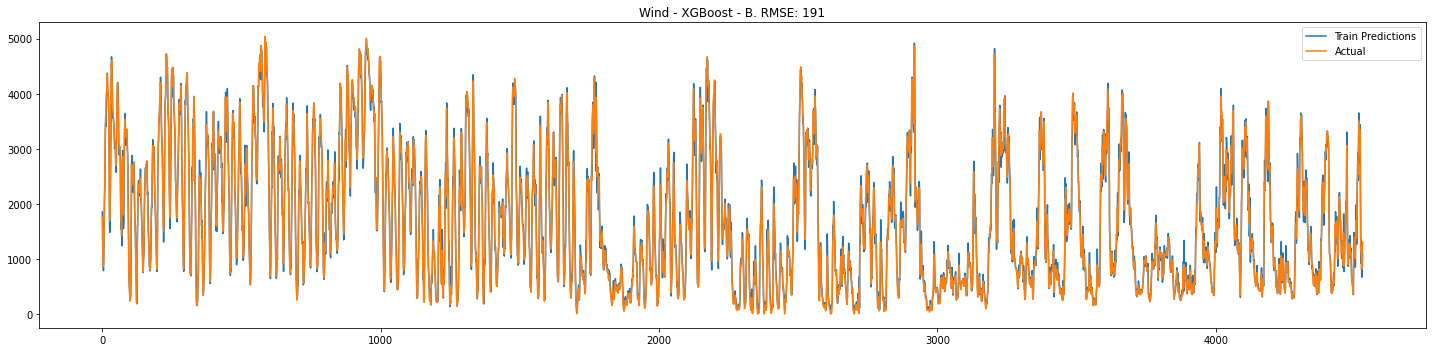

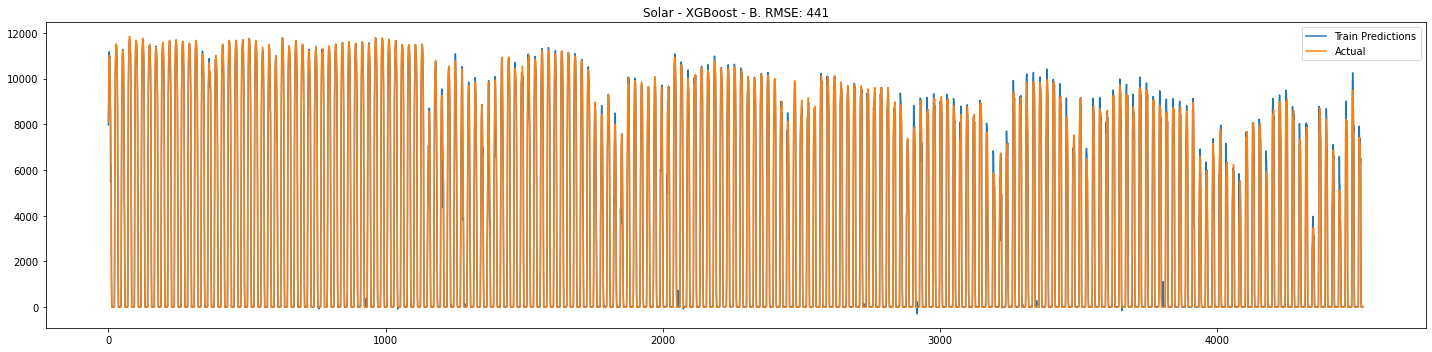

In [137]:
estimators, max_depth, lrt = 1000, 5, .01
wind_xgb_B_t = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
wind_xgb_B_t.fit(X_train_all_wind_4_i, y_train_all_wind_4_i)
_, rmse = plot_predictions(wind_xgb_B_t, X_test_wind_4_i, y_test_wind_4_i,title='Wind - XGBoost - B.', save=True)

estimators, max_depth, lrt = 1000, 10, .01
solar_xgb_B_t = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
solar_xgb_B_t.fit(X_train_all_solar_4_i, y_train_all_solar_4_i)
_, rmse = plot_predictions(solar_xgb_B_t, X_test_solar_4_i, y_test_solar_4_i,title='Solar - XGBoost - B.', save=True)

### C) Using the last four sequences of the entire dataset

In [143]:
estimators, max_depth, lrt = 500, 5, .01
wind_xgb_C = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
wind_xgb_C.fit(X_train_wind_4_2d, y_train_wind_4)
_, rmse = plot_predictions(wind_xgb_C, X_valid_wind_4_2d, y_valid_wind_4, title='WIND XGBoost Training.', save=False, show=False)
print('WIND', rmse)

estimators, max_depth, lrt = 500, 10, .01
solar_xgb_C = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
solar_xgb_C.fit(X_train_solar_4_2d, y_train_solar_4)
_, rmse = plot_predictions(solar_xgb_C, X_valid_solar_4_2d, y_valid_solar_4, title='SOLAR XGBoost Training.', save=False, show=False)
print('SOLAR', rmse)

# 282 1584

WIND 310.5823922686852
SOLAR 1532.1106801730875


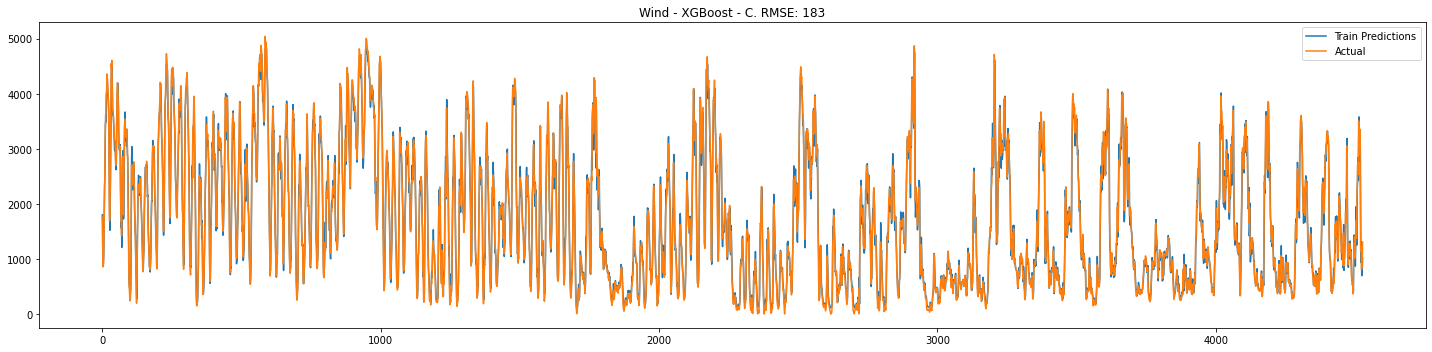

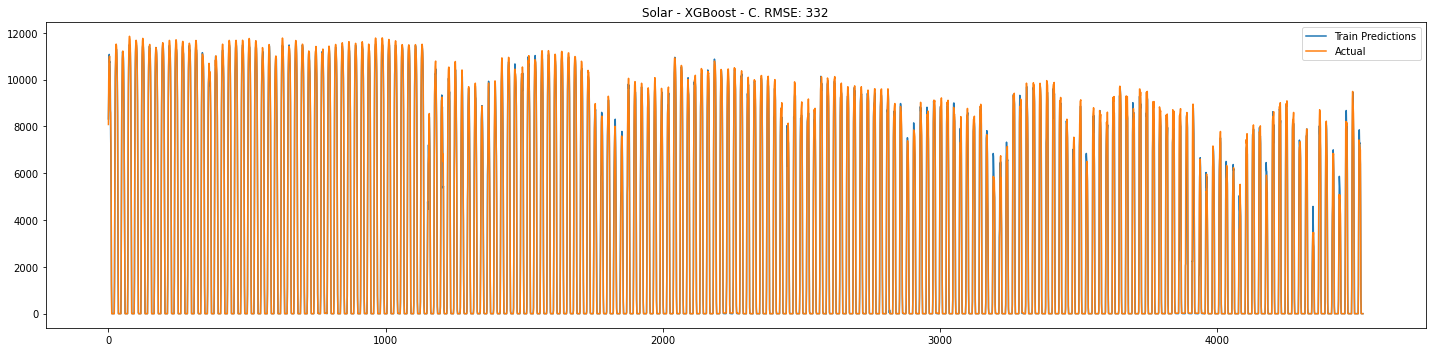

In [144]:
estimators, max_depth, lrt = 1000, 5, .01
wind_xgb_C_t = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
wind_xgb_C_t.fit(X_train_all_wind_4_2d, y_train_all_wind_4)
_, rmse = plot_predictions(wind_xgb_C_t, X_test_wind_4_2d, y_test_wind_4,title='Wind - XGBoost - C.', save=True)

estimators, max_depth, lrt = 1000, 10, .01
solar_xgb_C_t = GradientBoostingRegressor(n_estimators = estimators, max_depth = max_depth, learning_rate = lrt, loss = 'huber')
solar_xgb_C_t.fit(X_train_all_solar_4_2d, y_train_all_solar_4)
_, rmse = plot_predictions(solar_xgb_C_t, X_test_solar_4_2d, y_test_solar_4,title='Solar - XGBoost - C.', save=True)

## 4. SVM Regressor

### A) Using only the meteorological dataset as X

In [9]:
kernel = 'rbf'
gamma = 0.015
C = 2000

wind_svr_A = SVR(kernel = kernel, C=C, gamma=gamma)
wind_svr_A.fit(X_train_wind, y_train_wind)
_, rmse = plot_predictions(wind_svr_A, X_valid_wind, y_valid_wind, title='WIND SVM Training.', save=False, show=False)
print('WIND', rmse)

solar_svr_A = SVR(kernel = kernel, C=C, gamma=gamma)
solar_svr_A.fit(X_train_solar, y_train_solar)
_, rmse = plot_predictions(solar_svr_A, X_valid_solar, y_valid_solar, title='SOLAR SVM Training.', save=False, show=False)
print('SOLAR', rmse)

WIND 1089.2753950825056
SOLAR 1868.2899474639282


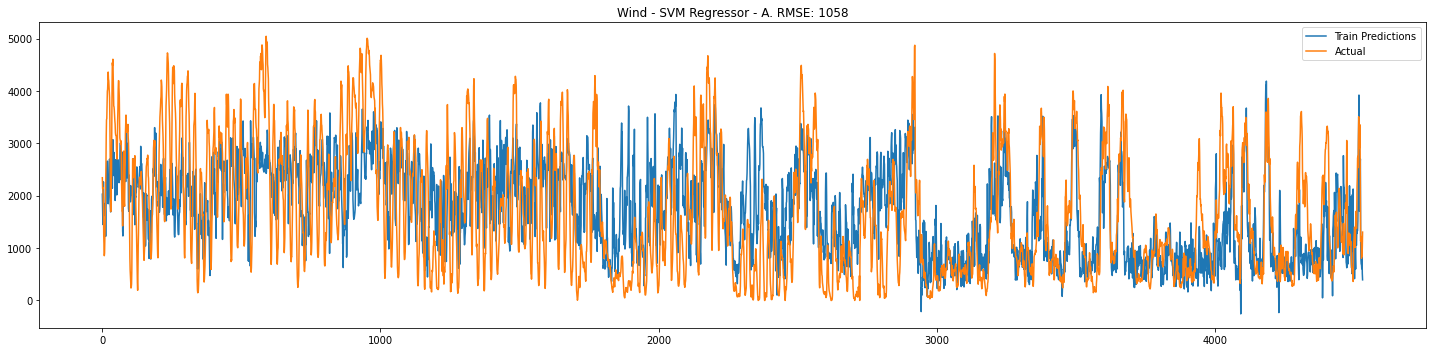

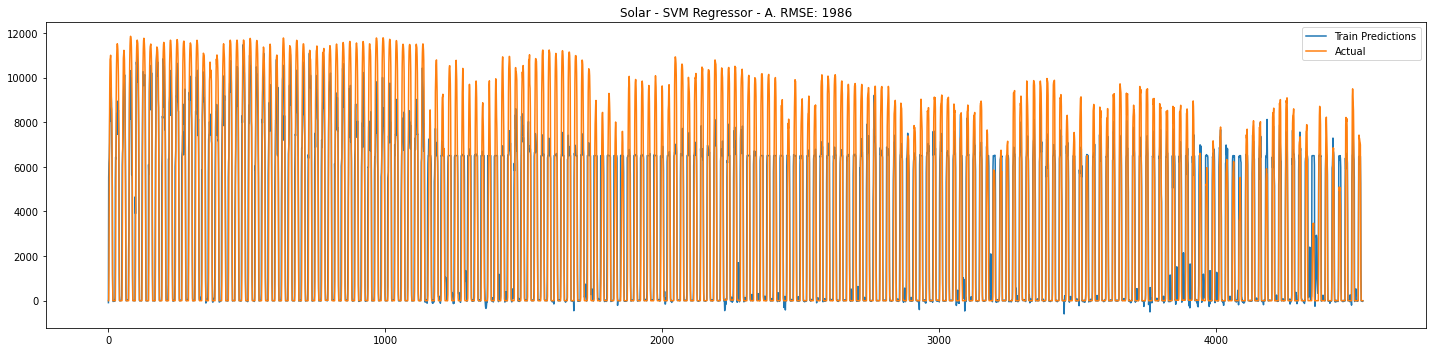

In [10]:
wind_svr_A_t = SVR(kernel = kernel, C=C, gamma=gamma)
wind_svr_A_t.fit(X_train_all_wind, y_train_all_wind)
_, rmse = plot_predictions(wind_svr_A_t, X_test_wind, y_test_wind,title='Wind - SVM Regressor - A.', save=True)

solar_svr_A_t = SVR(kernel = kernel, C=C, gamma=gamma)
solar_svr_A_t.fit(X_train_all_solar, y_train_all_solar)
_, rmse = plot_predictions(solar_svr_A_t, X_test_solar, y_test_solar,title='Solar - SVM Regressor - A.', save=True)

### B) Using the last four sequences of the generation dataset as X

In [11]:
kernel = 'rbf'
gamma = 0.000005
C = 5000

wind_svr_B = SVR(kernel = kernel, C=C, gamma=gamma)
wind_svr_B.fit(X_train_wind_4_i, y_train_wind_4_i)
_, rmse = plot_predictions(wind_svr_B, X_valid_wind_4_i, y_valid_wind_4_i, title='WIND SVM Training.', save=False, show=False)
print('WIND', rmse)

solar_svr_B = SVR(kernel = kernel, C=C, gamma=gamma)
solar_svr_B.fit(X_train_solar_4_i, y_train_solar_4_i)
_, rmse = plot_predictions(solar_svr_B, X_valid_solar_4_i, y_valid_solar_4_i, title='SOLAR SVM Training.', save=False, show=False)
print('SOLAR', rmse)

WIND 247.0835588160248
SOLAR 1151.7297954515532


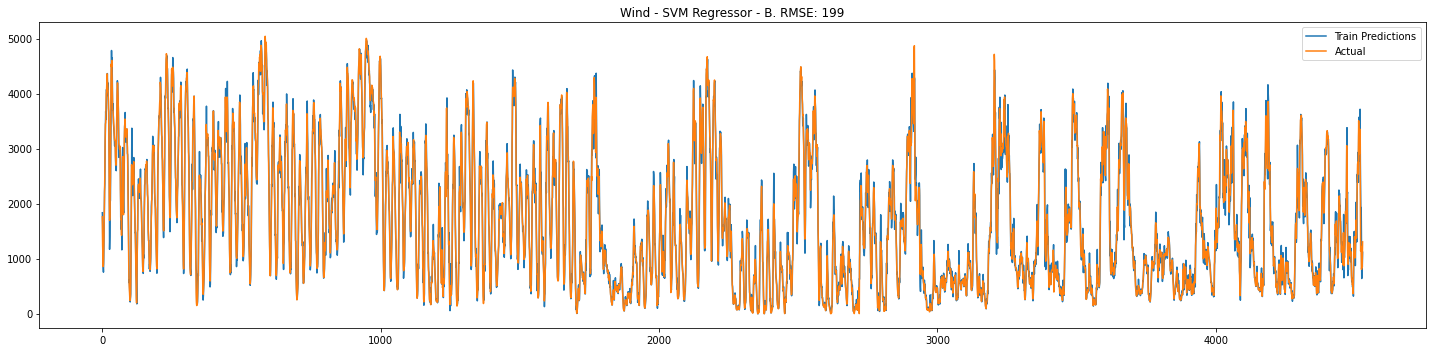

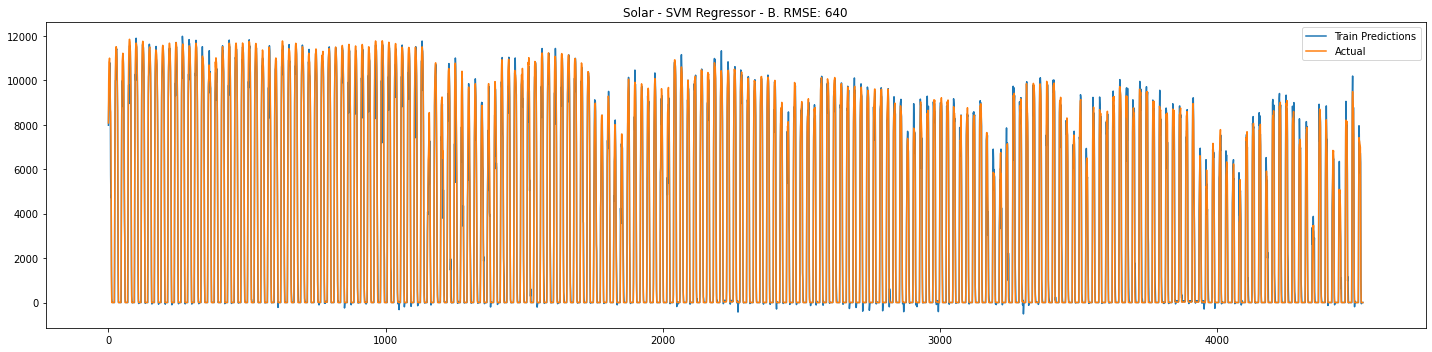

In [12]:
wind_svr_B_t = SVR(kernel = kernel, C=C, gamma=gamma)
wind_svr_B_t.fit(X_train_all_wind_4_i, y_train_all_wind_4_i)
_, rmse = plot_predictions(wind_svr_B_t, X_test_wind_4_i, y_test_wind_4_i,title='Wind - SVM Regressor - B.', save=True)

solar_svr_B_t = SVR(kernel = kernel, C=C, gamma=gamma)
solar_svr_B_t.fit(X_train_all_solar_4_i, y_train_all_solar_4_i)
_, rmse = plot_predictions(solar_svr_B_t, X_test_solar_4_i, y_test_solar_4_i,title='Solar - SVM Regressor - B.', save=True)

### C) Using the last four sequences of the entire dataset

In [64]:
kernel = 'rbf'
gamma = 0.00000005
C = 7000

wind_svr_C = SVR(kernel = kernel, C=C, gamma=gamma)
wind_svr_C.fit(X_train_wind_4_2d[:1000], y_train_wind_4[:1000])
_, rmse = plot_predictions(wind_svr_C, X_valid_wind_4_2d, y_valid_wind_4, title='WIND SVM Training.', save=False, show=False)
print('WIND', rmse)

solar_svr_C = SVR(kernel = kernel, C=C, gamma=gamma)
solar_svr_C.fit(X_train_solar_4_2d[:1000], y_train_solar_4[:1000])
_, rmse = plot_predictions(solar_svr_C, X_valid_solar_4_2d, y_valid_solar_4, title='SOLAR SVM Training.', save=False, show=False)
print('SOLAR', rmse)

WIND 228.69161831583057
SOLAR 625.6258648148878


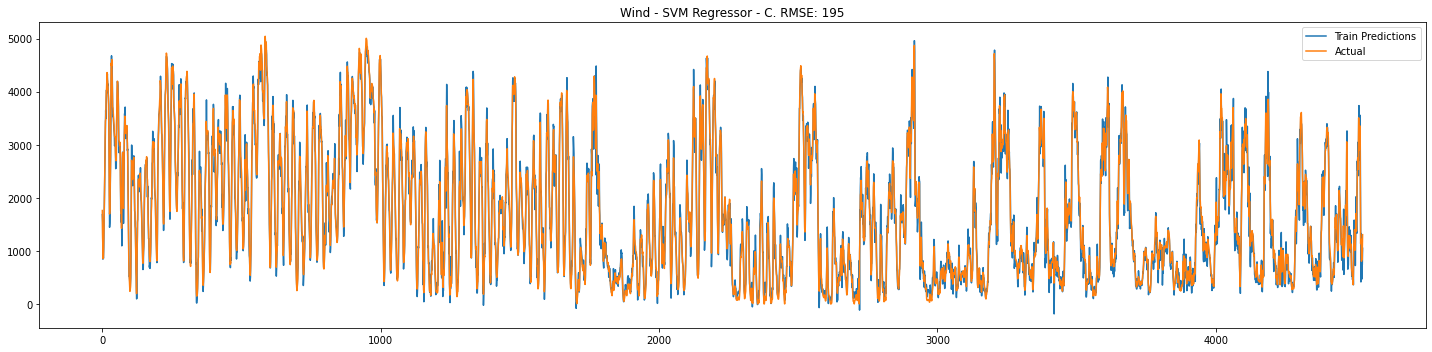

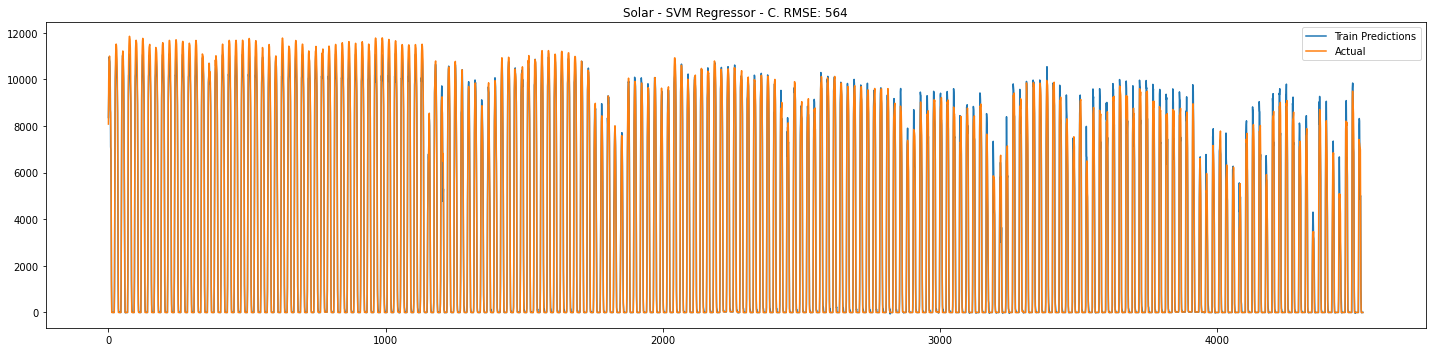

In [65]:
wind_svr_C_t = SVR(kernel = kernel, C=C, gamma=gamma)
wind_svr_C_t.fit(X_train_all_wind_4_2d, y_train_all_wind_4)
_, rmse = plot_predictions(wind_svr_C_t, X_test_wind_4_2d, y_test_wind_4,title='Wind - SVM Regressor - C.', save=True)

solar_svr_C_t = SVR(kernel = kernel, C=C, gamma=gamma)
solar_svr_C_t.fit(X_train_all_solar_4_2d, y_train_all_solar_4)
_, rmse = plot_predictions(solar_svr_C_t, X_test_solar_4_2d, y_test_solar_4,title='Solar - SVM Regressor - C.', save=True)